In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import norm, multivariate_normal

In [2]:
# population 0

c0_mu1 = 5.0
c0_mu2 = 0.0

c0_sigma1 = 5
c0_sigma2 = 3

c0_mu = [c0_mu1, c0_mu2]
c0_cov_matrix = np.identity(2) # identity matrix
c0_cov_matrix[0, 0] = c0_sigma1**2
c0_cov_matrix[1, 1] = c0_sigma2**2

In [3]:
# population 1

c1_mu1 = 0.0
c1_mu2 = 5.0

c1_sigma1 = 3
c1_sigma2 = 5

c1_mu = [c1_mu1, c1_mu2]
c1_cov_matrix = np.identity(2) # identity matrix
c1_cov_matrix[0, 0] = c1_sigma1**2
c1_cov_matrix[1, 1] = c1_sigma2**2

In [4]:
Ntot = 1000

c0_samples = np.random.multivariate_normal(c0_mu, c0_cov_matrix, Ntot)
c0_labels = np.zeros(Ntot)

c1_samples = np.random.multivariate_normal(c1_mu, c1_cov_matrix, Ntot)
c1_labels = np.ones(Ntot)

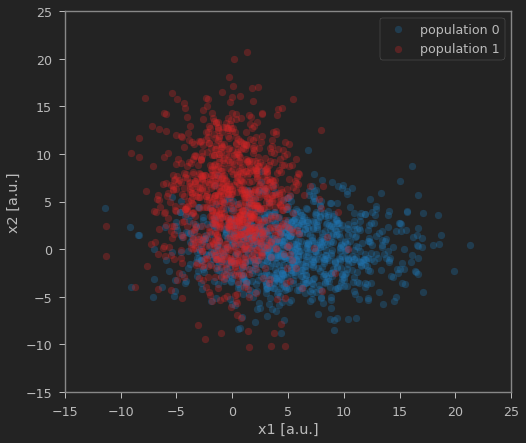

In [5]:
def add_scatter_points(samples, color, label):
    x1 = samples[:, 0]
    x2 = samples[:, 1]
    plt.scatter(x1, x2, label=label, color=color, alpha=0.3)
    
add_scatter_points(c0_samples, label="population 0", color="tab:blue")
add_scatter_points(c1_samples, label="population 1", color="tab:red")

plt.xlabel("x1 [a.u.]")
plt.ylabel("x2 [a.u.]")

plt.xlim([-15, 25])
plt.ylim([-15, 25])

plt.legend()

Text(0, 0.5, 'p1(z)')

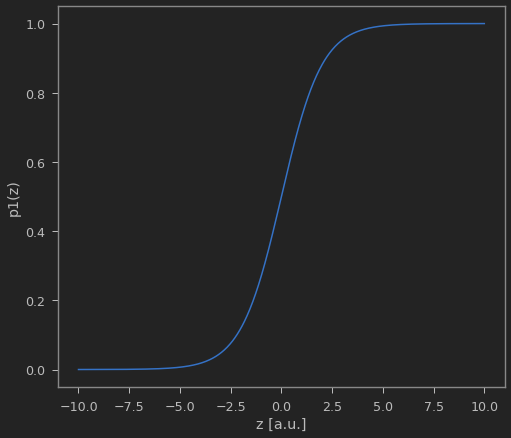

In [6]:
# let's have a look at the sigmoid function

xvals = np.linspace(-10, 10, 1000)
yvals = 1. / (1. + np.exp(-xvals))

plt.plot(xvals, yvals)
plt.xlabel("z [a.u.]")
plt.ylabel("p1(z)")

In [7]:
from scipy.stats import bernoulli
p1 = 0.3
print("fail probability mass:", bernoulli.pmf(0, p1))
print("success probability mass", bernoulli.pmf(1, p1))

fail probability mass: 0.7000000000000001
success probability mass 0.3


In [8]:
def neg_logl(pars, samples, labels):
    weights = pars[:2]
    b = pars[2]
    
    # compute z vector from all our samples
    zs = np.dot(weights, samples.T) + b
    
    # now run through sigmoid
    ps = 1./ (1 + np.exp(-zs))

    # and now calculate the neg_logl
    ll = np.sum(bernoulli.logpmf(labels, ps))
    return -ll

In [9]:
# combine samples
combined_samples = np.vstack([c0_samples, c1_samples])
combined_labels = np.concatenate([c0_labels, c1_labels])

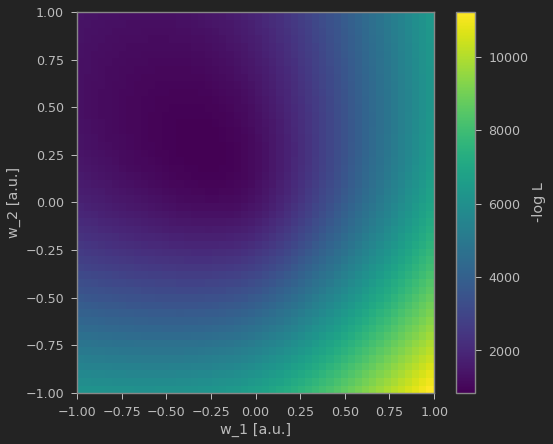

In [10]:
# plot log llh functions at fixed intercept vector
b = 0.0

edges = np.linspace(-1, 1, 51)
centers = 0.5*(edges[:-1] + edges[1:])

xv, yv = np.meshgrid(centers, centers, sparse=False, indexing='xy')
pos = np.stack([xv.flatten(), yv.flatten()], axis=1)
pars = np.column_stack([pos, b * np.ones(len(pos))])

nlls = np.array([neg_logl(tpars, combined_samples, combined_labels) for tpars in pars])


fig, ax = plt.subplots()
h = ax.hist2d(xv.flatten(), yv.flatten(), bins=[edges]*2, weights = nlls.flatten())
ax.set_xlabel("w_1 [a.u.]")
ax.set_ylabel("w_2 [a.u.]")

cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label("-log L")

plt.show()


   direc: array([[ 1.74170296e-02, -1.63541000e-03, -2.82052160e-02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 6.71053436e-06,  8.82481863e-04, -7.27422003e-03]])
     fun: 851.5919975458867
 message: 'Optimization terminated successfully.'
    nfev: 224
     nit: 6
  status: 0
 success: True
       x: array([-0.29181647,  0.29150381, -0.0085546 ])


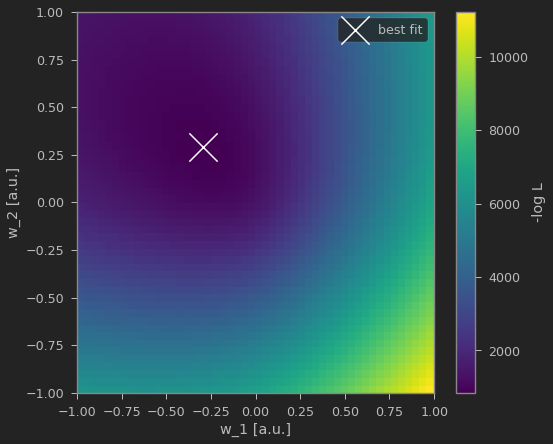

In [11]:
# now do the actual optimization!

from scipy.optimize import minimize

starting_slopes = np.array([-1., 1])
starting_intercepts = np.array([0.0])
pars_starting_point = np.concatenate([starting_slopes, starting_intercepts])

obj = lambda x: neg_logl(x, combined_samples, combined_labels)
r = minimize(obj, pars_starting_point, method='Powell')

print(r)

best_pars = r.x

fig, ax = plt.subplots()
h = ax.hist2d(xv.flatten(), yv.flatten(), bins=[edges]*2, weights = nlls.flatten())
ax.set_xlabel("w_1 [a.u.]")
ax.set_ylabel("w_2 [a.u.]")

ax.scatter([r.x[0]], [r.x[1]], marker="x", s=800, color='white', label='best fit')

cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label("-log L")
ax.legend()

plt.show()

In [12]:
# now we can make predictions for p from this logistic regression model.
# assuming the best-fit parameters
# and taking some observations x1, x2 as input

def get_p(x, pars):
    weights = pars[:2]
    bs = pars[2:]
    z = np.dot(weights, x.T)
    p = 1./ (1 + np.exp(-z))
    return p

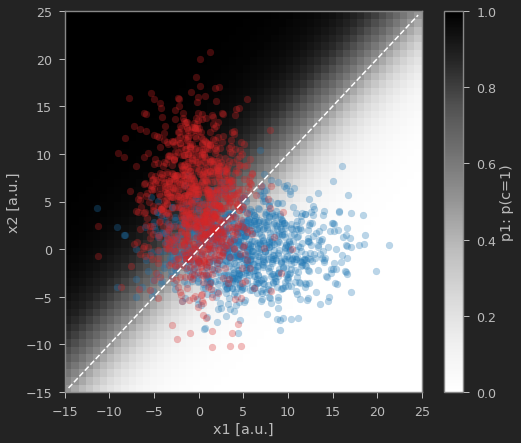

In [13]:
from matplotlib.colors import Normalize
edges = np.linspace(-15, 25, 51)
centers = 0.5*(edges[:-1] + edges[1:])

xv, yv = np.meshgrid(centers, centers, sparse=False, indexing='xy')
pos = np.stack([xv.flatten(), yv.flatten()], axis=1)
p1s = get_p(pos, best_pars)

fig, ax = plt.subplots()
h = ax.hist2d(xv.flatten(), yv.flatten(), bins=[edges]*2, weights = p1s.flatten(), norm=Normalize(vmin=0.0, vmax = 1.0), cmap=plt.get_cmap('Greys'))
ax.set_xlabel("x1 [a.u.]")
ax.set_ylabel("x2 [a.u.]")

cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label("p1: p(c=1)")

add_scatter_points(c0_samples, label="population 0", color="tab:blue")
add_scatter_points(c1_samples, label="population 1", color="tab:red")

ax.contour(centers, centers, p1s.reshape(len(centers), len(centers)), [0.5], colors=['white'], linestyles=['dashed'])

plt.show()



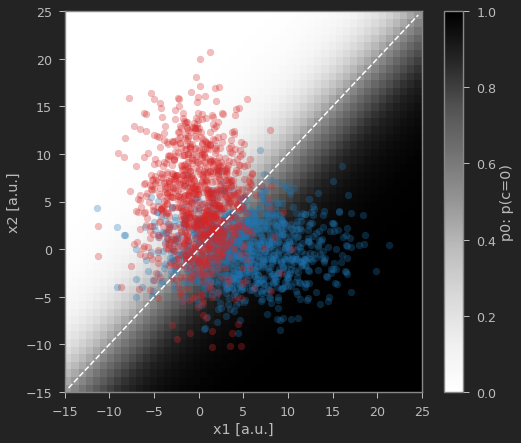

In [14]:
# p0 is 1 - p1 by definition

from matplotlib.colors import Normalize
edges = np.linspace(-15, 25, 51)
centers = 0.5*(edges[:-1] + edges[1:])

xv, yv = np.meshgrid(centers, centers, sparse=False, indexing='xy')
pos = np.stack([xv.flatten(), yv.flatten()], axis=1)
p1s = 1.-get_p(pos, best_pars)

fig, ax = plt.subplots()
h = ax.hist2d(xv.flatten(), yv.flatten(), bins=[edges]*2, weights = p1s.flatten(), norm=Normalize(vmin=0.0, vmax = 1.0), cmap=plt.get_cmap('Greys'))
ax.set_xlabel("x1 [a.u.]")
ax.set_ylabel("x2 [a.u.]")

cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label("p0: p(c=0)")

add_scatter_points(c0_samples, label="population 0", color="tab:blue")
add_scatter_points(c1_samples, label="population 1", color="tab:red")

ax.contour(centers, centers, 1.-p1s.reshape(len(centers), len(centers)), [0.5], colors=['white'], linestyles=['dashed'])

plt.show()